In [1]:
import numpy as np
import random
import pandas as pd
import sklearn

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import preprocessing
# from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from biclustering import DeltaBiclustering, MSR

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
def generate_dataset(option, noise=1, noise_background=True, shuffle=False):
    """
    This function generates syntetic datasets as described in the paper
    (http://cs-people.bu.edu/panagpap/Research/Bio/bicluster_survey.pdf)
    - Figure 4.
    
    Params
        option (str): bicluster structure ('a' to 'i')
        noise (int): value of the noise in the matrix
        noise_background (bool): positions where is not a bicluster should contain noise
            if this parameter is set to True
        shuffle (bool): shuffle lines and columns of the matrix if this parameter is set
            to True

    Returns
        data (array_like): matrix generated
    """
    shape = (150,150)
    n,m = shape
    
    # values shouldn't be a lot far...
    centers = [20, 40, 60, 80, 100]
    
    y_row = np.zeros(150)
    y_col = np.zeros(150)

    if noise_background:
        data = np.random.rand(n, m)*100
    else:
        data = np.zeros(n*m).reshape(shape)

    if option == 'a':
        data[60:110][:,70:140] = np.random.rand(50,70)*noise + centers[0]
        y_row[60:110] += 1
        y_col[70:140] += 1
    elif option == 'd':
        data[0:50][:,0:70] = np.random.rand(50,70)*noise + centers[0]
        y_row[0:50] += 1
        y_col[0:70] += 1

        data[50:100][:,50:100] = np.random.rand(50,50)*noise + centers[2]
        y_row[50:100] += 2
        y_col[50:100] += 2

        data[100:150][:,80:150] = np.random.rand(50,70)*noise + centers[1]
        y_row[100:150] += 3
        y_col[80:150] += 3
    elif option == 'e':
        data[0:70][:,0:50] = np.random.rand(70,50)*noise + centers[3]
        y_row[0:70] += 1
        y_col[0:50] += 1

        data[50:100][:,50:100] = np.random.rand(50,50)*noise + centers[1]
        y_row[50:100] += 2
        y_col[50:100] += 2

        data[80:150][:,100:150] = np.random.rand(70,50)*noise + centers[2]
        y_row[80:150] += 3
        y_col[100:150] += 3
    elif option == 'f':
        data[0:50][:,0:40] = np.random.rand(50,40)*noise + centers[4]
        y_row[0:50] += 1
        y_col[0:40] += 1

        data[50:150][:,0:40] = np.random.rand(100,40)*noise + centers[0]
        y_row[50:150] += 2

        data[110:150][:,40:95] = np.random.rand(40,55)*noise + centers[2]
        y_row[110:150] += 3
        y_col[40:95] += 2

        data[110:150][:,95:150] = np.random.rand(40,55)*noise + centers[1]
        y_row[110:150] += 3
        y_col[95:150] += 3
    elif option == 'g':
        data[0:110][:,0:40] = np.random.rand(110,40)*noise + centers[0]
        data[110:150][:,0:110] = np.random.rand(40,110)*noise + centers[2]
        data[40:150][:,110:150] = np.random.rand(110,40)*noise + centers[1]
        data[0:40][:,40:150] = np.random.rand(40,110)*noise + centers[3]
    elif option == 'h':
        data[0:90][:,0:90] = np.random.rand(90,90)*noise + centers[0]
        data[35:55][:,35:55] = (np.random.rand(20,20)*noise + centers[1]) + data[35:55][:,35:55]
        data[110:140][:,35:90] = np.random.rand(30,55)*noise + centers[4]
        data[0:140][:,110:150] = np.random.rand(140,40)*noise + centers[2]
        data[0:55][:,130:150] = (np.random.rand(55,20)*noise + centers[3]) + data[0:55][:,130:150]
    elif option == 'i':
        data[20:70][:,20:70] = np.random.rand(50,50)*noise + centers[0]
        data[20:70][:,100:150] = np.random.rand(50,50)*noise + centers[1]
        data[50:110][:,50:120] = np.random.rand(60,70)*noise + centers[2]
        data[120:150][:,20:100] = np.random.rand(30,80)*noise + centers[3]

    if shuffle:
        np.random.shuffle(data)
        np.random.shuffle(data.T)

    return data, y_row, y_col

In [51]:
from numba import jit

@jit(nopython=True)
def compute_U(S, V, m, k):
    V_tilde = np.dot(S, V.T)
    U_new = np.empty([m, k])
    for i in xrange(m):
        errors = np.empty(k)
        for row_clust_ind in xrange(k):
            errors[row_clust_ind] = np.sum((X[i][:] - V_tilde[row_clust_ind][:])**2)
        ind = np.argmin(errors)
        U_new[i][ind] = 1
    return U_new

def fnmtf(X, k, l, num_iter=10, norm=True):
    m, n = X.shape

    U = np.random.rand(m,k)
    S = np.random.rand(k,l)
    V = np.random.rand(n,l)

    if norm:
        X = preprocessing.normalize(X)
    for i in xrange(num_iter):
        S = pinv(U.T.dot(U)).dot(U.T).dot(X).dot(V).dot(pinv(V.T.dot(V)))

        # solve subproblem to update V
        U_tilde = U.dot(S)
        V_new = np.zeros(n*l).reshape(n, l)
        for j in range(n):
            errors = np.zeros(l)
            for col_clust_ind in xrange(l):
                errors[col_clust_ind] = ((X[:][:, j] - U_tilde[:][:, col_clust_ind])**2).sum()
            ind = np.argmin(errors)
            V_new[j][ind] = 1
        V = V_new

#         while np.linalg.det(V.T.dot(V)) <= 0:
#             erros = (X - U.dot(S).dot(V.T)) ** 2
#             erros = np.sum(erros.dot(V), axis=0) / np.sum(V, axis=0)
#             erros[np.where(np.sum(V, axis=0) <= 1)] = -inf
#             quantidade = np.sum(V, axis=0)
#             indexMin = np.argmin(quantidade)
#             indexMax = np.argmax(erros)
#             indexes = np.nonzero(V[:, indexMax])[0]
#             for j in indexes:
#                 if np.random.rand(1) > 0.5:
#                     V[j, indexMax] = 0
#                     V[j, indexMin] = 1

        # solve subproblem to update U
        U = compute_U(S, V, m, k)

#         while np.linalg.det(U.T.dot(U)) <= 0:
#             erros = (X - U.dot(V_tilde)) ** 2
#             erros = np.sum(U.T.dot(erros), axis=1) / np.sum(U, axis=0)
#             erros[np.where(np.sum(U, axis=0) <= 1)] = -np.inf
#             quantidade = np.sum(U, axis=0)
#             indexMin = np.argmin(quantidade)
#             indexMax = np.argmax(erros)
#             indexes = np.nonzero(U[:, indexMax])[0]

#             end = len(indexes)
#             indexes_p = np.random.permutation(end)
#             U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMax] = 0.0
#             U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMin] = 1.0

    rows_ind = np.argmax(U, axis=1)
    cols_ind = np.argmax(V, axis=1)

    return U, S, V, rows_ind, cols_ind

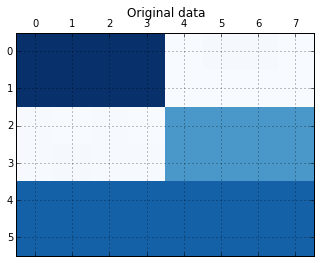

In [3]:
# m, n = (40, 35)
# X = .01 * np.random.rand(m,n)
# X[0:10][:, 0:10] = 1 + .01 * np.random.random()
# X[30:40][:, 20:35] = 1 + .01 * np.random.random()
# X[20:30][:, 20:35] = .6 + .01 * np.random.random()
# X[30:40][:, 36:40] = 1 + .01 * np.random.random()

# m, n = (6, 8)
# X = .01 * np.random.rand(m,n)
# X[0:2][:, 0:4] = 1 + .01 * np.random.random()
# X[2:4][:, 4:8] = .6 + .01 * np.random.random()
# X[4:6][:, 0:8] = .8 + .01 * np.random.random()

plt.matshow(X, cmap=plt.cm.Blues)
plt.title('Original data')
plt.grid()
plt.show()

In [53]:
U, S, V, rows_ind, cols_ind = fnmtf(X, 3, 2, norm=False)

def plot_factorization_result(U, S, V):
    fig = plt.figure()
    
    ax = fig.add_subplot(2, 2, 1)
    ax.matshow(U.dot(S).dot(V.T), cmap=plt.cm.Blues)
    ax.set_title('reconstruction')
    ax.grid()
    
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.matshow(U, cmap=plt.cm.Blues)
    ax2.set_title('U*S')
    ax2.grid()

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.matshow(S, cmap=plt.cm.Blues)
    ax3.set_title('S')
    ax3.grid()

    ax4 = fig.add_subplot(2, 2, 4)
    ax4.matshow(V.T, cmap=plt.cm.Blues)
    ax4.set_title('S*V\'')
    ax4.grid()
    
    plt.show()


def scores(labels_true, labels_pred, row=True):
    if row:
        print 'Rows scores'
    else:
        print 'Cols scores'
    print 'Random score: %s' % adjusted_rand_score(labels_true, labels_pred)
    print 'Normalized mutual information score: %s' % normalized_mutual_info_score(labels_true, labels_pred)
    print ''

plot_factorization_result(U, S, V)
scores(rows_ind, [0, 0, 1, 1, 2, 2])
scores(cols_ind, [0, 0, 0, 0, 1, 1, 1, 1], row=False)

TypingError: Caused By:
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/numba/compiler.py", line 243, in run
    res = stage()
  File "/usr/local/lib/python2.7/site-packages/numba/compiler.py", line 463, in stage_nopython_frontend
    self.locals)
  File "/usr/local/lib/python2.7/site-packages/numba/compiler.py", line 780, in type_inference_stage
    infer.propagate()
  File "/usr/local/lib/python2.7/site-packages/numba/typeinfer.py", line 565, in propagate
    raise errors[0]
TypingError: Invalid usage of Function(<built-in function empty>) with parameters (list(int64))
 * parameterized
File "<ipython-input-51-b9f182fd0a71>", line 6

Failed at nopython (nopython frontend)
Invalid usage of Function(<built-in function empty>) with parameters (list(int64))
 * parameterized
File "<ipython-input-51-b9f182fd0a71>", line 6

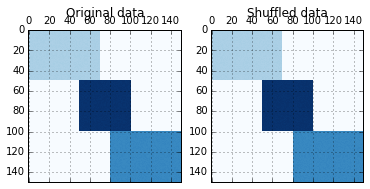

In [17]:
X, x_labels, y_labels = generate_dataset('d', noise_background=False, shuffle=False)
temp, _, _ = generate_dataset('d', noise_background=False)

fig = plt.figure()
    
ax1 = fig.add_subplot(1, 2, 1)
ax1.matshow(temp, cmap=plt.cm.Blues)
ax1.set_title('Original data')
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2)
ax2.matshow(X, cmap=plt.cm.Blues)
ax2.set_title('Shuffled data')
ax2.grid()

plt.show()

dt: 0.0820469856262 secs


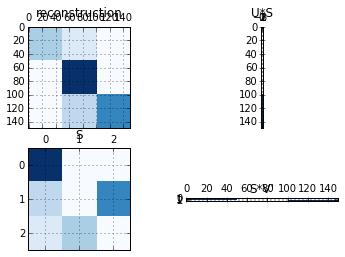

Rows scores
Random score: 1.0
Normalized mutual information score: 1.0

Cols scores
Random score: 0.640096618357
Normalized mutual information score: 0.722428192022



In [27]:
import time
t1 = time.time()
U, S, V, rows_ind, cols_ind = fnmtf(X, 3, 3, norm=False)
t2 = time.time()
print ('dt: {} secs'.format(t2-t1))
plot_factorization_result(U, S, V)
scores(rows_ind, x_labels)
scores(cols_ind, y_labels, row=False)

In [54]:
%load_ext Cython

In [79]:
%%cython

import cython
cimport cython

import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
def fnmtf_improved(double[:, ::1] X, int k, int l, int num_iter=100, int norm=0):
    cdef int m = X.shape[0]
    cdef int n = X.shape[1]

    cdef unsigned int i = 0
    cdef unsigned int j = 0
    cdef unsigned int iter_index = 0
    cdef unsigned int row_clust_ind = 0
    cdef unsigned int col_clust_ind = 0
    cdef unsigned int ind = 0

    cdef double[:, ::1] U = np.random.rand(m, k).astype(np.float64)
    cdef double[:, ::1] U_best = np.random.rand(m, k).astype(np.float64)
    cdef double[:, ::1] S = np.random.rand(k, l).astype(np.float64)
    cdef double[:, ::1] S_best = np.random.rand(k, l).astype(np.float64)
    cdef double[:, ::1] V = np.random.rand(n, l).astype(np.float64)
    cdef double[:, ::1] V_best = np.random.rand(n, l).astype(np.float64)

    cdef double[:, ::1] U_tilde = np.empty((m, l), dtype=np.float64)
    cdef double[:, ::1] V_new = np.empty((n, l), dtype=np.float64)

    cdef double[:, ::1] V_tilde = np.empty((l, n), dtype=np.float64)
    cdef double[:, ::1] U_new = np.empty((m, k), dtype=np.float64)

    cdef double error_best = 10e9999
    cdef double error = 10e9999
    cdef double[:] errors_v = np.zeros(l, dtype=np.float64)
    cdef double[:] errors_u = np.zeros(k, dtype=np.float64)

    for iter_index in range(num_iter):
        S[:, :] = np.dot( np.dot(np.linalg.pinv(np.dot(U.T, U)), np.dot(np.dot(U.T, X), V)), np.linalg.pinv(np.dot(V.T, V)) )

        # solve subproblem to update V
        U_tilde[:, :] = np.dot(U, S)
        V_new[:, :] = np.empty((n, l), dtype=np.int)
        for j in range(n):
            errors_v = np.zeros(l, dtype=np.float64)
            for col_clust_ind in range(l):
                errors_v[col_clust_ind] = np.sum(np.square(np.subtract(X[:, j], U_tilde[:, col_clust_ind])))
            ind = np.argmin(errors_v)
            V_new[j, ind] = 1.0
        V[:, :] = V_new

        # solve subproblem to update U
        V_tilde[:, :] = np.dot(S, V.T)
        U_new[:, :] = np.empty((m, k), dtype=np.int)
        for i in range(m):
            errors_u = np.zeros(k, dtype=np.float64)
            for row_clust_ind in range(k):
                errors_u[row_clust_ind] = np.sum(np.square(np.subtract(X[i, :], V_tilde[row_clust_ind, :])))
            ind = np.argmin(errors_u)
            U_new[i, ind] = 1.0
        U[:, :] = U_new

        error_ant = error
        error = np.sum(np.square(np.subtract(X, np.dot(np.dot(U, S), V.T))))

        if error < error_best:
            U_best[:, :] = U
            S_best[:, :] = S
            V_best[:, :] = V
            error_best = error

In [80]:
import time
X, x_labels, y_labels = generate_dataset('d', noise_background=False, shuffle=False)
t1 = time.time()
U, S, V, rows_ind, cols_ind = fnmtf_improved(X, 3, 3)
t2 = time.time()
print ('dt: {} secs'.format(t2-t1))
plot_factorization_result(U, S, V)
scores(rows_ind, x_labels)
scores(cols_ind, y_labels, row=False)

TypeError: only length-1 arrays can be converted to Python scalars